# Image classification with Vision Transformer

**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)] for image classification,
and demonstrates it on the CIFAR-100 dataset [60.000 images (50.000 for training, 10.000 for testing), 100 classes].
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup Keras as backend and import library

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Configure the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2 #Number of patches per image
projection_dim = 64 #dmodel
num_heads = 4 #Number of heads for Multi-head attention layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier


## Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(), #chuẩn hóa độ sáng, độ tương phản
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"), #lật ngang ngẫu nhiên
        layers.RandomRotation(factor=0.02), #xoay ảnh ngẫu nhiên với biên độ xoay 2% (+- 7.2 độ)
        layers.RandomZoom(height_factor=0.2, width_factor=0.2), #phóng to, thu nhỏ với tỷ lệ tối đa 20%
    ],
    name="data_augmentation",
)
# tính toán trung bình và độ lệch chuẩn của toàn bộ ảnh trong x_train, lưu trữ trong các thuộc tính của lớp Normalization
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [6]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
      #tạo 1 lớp dense với units neuron, áp dụng GELU
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w, #number of patches
                self.patch_size * self.patch_size * channels, #size of vector of each patch
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


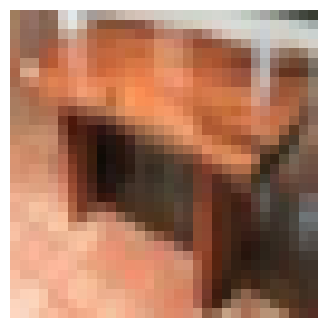

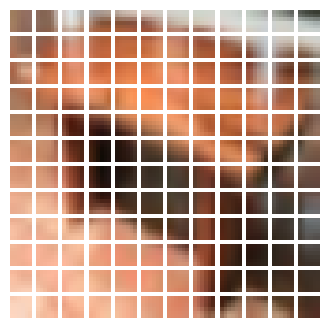

In [8]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [9]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [10]:

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        #Multi-Head Attention nhận hai đầu vào (query và key-value). Trong trường hợp này, cả query và key-value đều là x1, cho thấy rằng đây là self-attention
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:

# model_save_folder = "/content/gdrive/My Drive/models"
# os.makedirs(model_save_folder, exist_ok=True)

# def run_experiment(model):
#     optimizer = keras.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )

#     model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
#         ],
#     )

#     # Define callback for saving models
#     checkpoint_filepath = os.path.join(model_save_folder, "weights-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor="val_accuracy",
#     save_best_only=False,
#     save_weights_only=True,
#     )

#     history = model.fit(
#         x=x_train,
#         y=y_train,
#         batch_size=batch_size,
#         epochs=40,
#         initial_epoch=18,
#         validation_split=0.1,
#         callbacks=[checkpoint_callback],
#     )

#     # Evaluate the latest model
#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

#     return history

# # Create the model
# vit_classifier = create_vit_classifier()

# # Run the experiment (resume_training=True to continue from a saved checkpoint)
# history = run_experiment(vit_classifier)

# # Plot the training history
# def plot_history(item):
#     plt.plot(history.history[item], label=item)
#     plt.plot(history.history["val_" + item], label="val_" + item)
#     plt.xlabel("Epochs")
#     plt.ylabel(item)
#     plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
#     plt.legend()
#     plt.grid()
#     plt.show()

# plot_history("loss")
# plot_history("top-5-accuracy")


In [ ]:
from tensorflow.keras.models import load_model

# Tạo thư mục lưu weights
model_save_folder = "/content/gdrive/My Drive/models"
os.makedirs(model_save_folder, exist_ok=True)

# Tạo lại mô hình
vit_classifier = create_vit_classifier()

# Đường dẫn đến weights đã lưu
latest_weights = os.path.join(model_save_folder, "weights-27-0.47.weights.h5")

# Kiểm tra và tải weights nếu tồn tại
if os.path.exists(latest_weights):
    print(f"Loading weights from {latest_weights}")
    vit_classifier.load_weights(latest_weights)

# Tiếp tục huấn luyện mô hình
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Define callback for saving weights
    checkpoint_filepath = os.path.join(model_save_folder, "weights-{epoch:02d}-{val_accuracy:.2f}.weights.h5")
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=False,
        save_weights_only=True,
    )

    # Huấn luyện tiếp từ epoch 10
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=50,  # Số epoch tổng cộng
        initial_epoch=27,  # Epoch bắt đầu (sau khi tải weights)
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Đánh giá mô hình sau khi huấn luyện
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

# Chạy thí nghiệm và tiếp tục huấn luyện
history = run_experiment(vit_classifier)

# Vẽ biểu đồ lịch sử huấn luyện
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_history("loss")
plot_history("accuracy")
plot_history("top-5-accuracy")


Loading weights from /content/gdrive/My Drive/models/weights-27-0.47.weights.h5
Epoch 28/50
126/176 ━━━━━━━━━━━━━━━━━━━━ 26:10 31s/step - accuracy: 0.5023 - loss: 1.8209 - top-5-accuracy: 0.8051